In [1]:
import sys
import os
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from tqdm import tqdm

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.preprocess_data import preprocess_data, format_data, split_data
from src.train_test import get_dataloaders, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# STOCK_PATH = "../data/apple_stock/AAPL_1980-12-03_2025-03-15.csv"
STOCK_PATHS = [
    "../data/maang_stocks/meta.csv",
    "../data/maang_stocks/amazon.csv",
    "../data/maang_stocks/apple.csv",
    "../data/maang_stocks/google.csv",
    "../data/maang_stocks/netflix.csv"
]
SENTIMENT_PATH = "../data/financial_tweets/financial_tweets_sentiments.csv"

WINDOW_SIZE = 14

In [3]:
df_train = []
df_val = []
df_test = []

train_prices = []
train_sentiments = []

for stock_path in tqdm(STOCK_PATHS):
    stock_name = stock_path.split("/")[-1].split(".csv")[0]

    if stock_name in ["netflix", "meta"]:
        date_col = "Date"
        price_col = "Close"
    else:
        date_col = "date"
        price_col = "close"

    df = preprocess_data(stock_path, SENTIMENT_PATH, stocks_date_col=date_col, stocks_price_col=price_col)
    df_train_, df_val_, df_test_ = split_data(df, split1=0.7, split2=0.9)
    
    df_train.append(df_train_)
    df_val.append(df_val_)
    df_test.append(df_test_)

    train_prices.append(df_train_["price"].values)
    train_sentiments.append(df_train_["sentiment"].values)

price_mean = np.mean(np.concatenate(train_prices))
price_std = np.std(np.concatenate(train_prices))

sentiment_mean = np.mean(np.concatenate(train_sentiments))
sentiment_std = np.std(np.concatenate(train_sentiments))

X_train, y_train = [], []
X_val, y_val = [], []

Xy_val = []
Xy_test = []

for i in range(len(df_train)):
    X_train_, y_train_, X_val_, y_val_, X_test_, y_test_ = format_data(df_train[i], df_val[i], df_test[i], price_mean, price_std, sentiment_mean, sentiment_std, WINDOW_SIZE)

    X_train.append(X_train_)
    y_train.append(y_train_)

    X_val.append(X_val_)
    y_val.append(y_val_)

    Xy_test.append((X_test_, y_test_))
    Xy_val.append((X_val_, y_val_))

X_train = torch.cat(X_train)
y_train = torch.cat(y_train)

X_val = torch.cat(X_val)
y_val = torch.cat(y_val)

# X_train, y_train, X_val, y_val, X_test, y_test, mean, std = split_and_format_data(df, window_size=WINDOW_SIZE, split1=0.7, split2=0.9)
train_dataloader, val_dataloader = get_dataloaders(X_train, y_train, X_val, y_val, batch_size=64)

print(f"Train set length = {len(X_train)}")
print(f"Val set length = {len(X_val)}")
print(f"Test set length (per stock) = {len(Xy_test[0][0])}")

100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


Train set length = 1295
Val set length = 270
Test set length (per stock) = 13


### No sentiment

[ Epoch 9990 / 10000 ] Train loss = 0.02007795472274579 Val loss = 0.2616942793363705 Best val loss = 0.2392751494422555


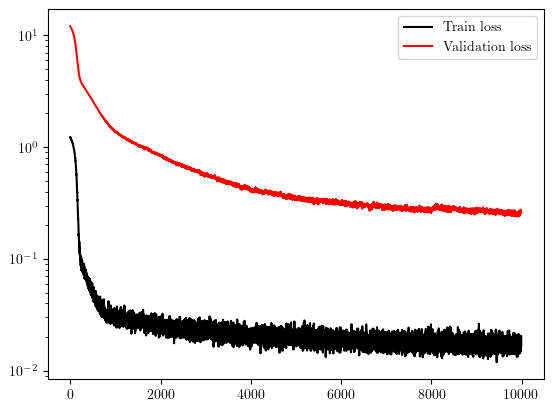

Best val loss: 0.2392751494422555


In [4]:
model_no_sentiment = train(train_dataloader=train_dataloader,
                           val_dataloader=val_dataloader,
                           sentiment=False,
                           lstm_hidden_size=64,
                           lstm_num_layers=1,
                           window_size=WINDOW_SIZE,
                           lr=1e-5,
                           epochs=10000,
                           use_scheduler=False,
                           scheduler_step=500,
                           scheduler_gamma=0.9,
                           weight_decay=1e-5,
                           dropout_rate=0.3,
                           device=device,
                           mlp_layers=0,
                           mlp_hidden_size=0)

### Sentiment

In [ ]:
model_sentiment = train(train_dataloader=train_dataloader,
                           val_dataloader=val_dataloader,
                           sentiment=True,
                           lstm_hidden_size=64,
                           lstm_num_layers=10000,
                           window_size=WINDOW_SIZE,
                           lr=1e-5,
                           epochs=1,
                           use_scheduler=False,
                           scheduler_step=500,
                           scheduler_gamma=0.9,
                           weight_decay=1e-5,
                           dropout_rate=0.3,
                           mlp_hidden_size=256,
                           mlp_layers=1,
                           device=device)

/Users/gregor/Documents/faks/deep_learning/project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Visualizations

### Validation set

[meta] No sentiment loss = 178.31998 USD
	Sentiment loss = 180.44431 USD

[amazon] No sentiment loss = 175.23647 USD
	Sentiment loss = 175.24960 USD

[apple] No sentiment loss = 175.29291 USD
	Sentiment loss = 175.36934 USD

[google] No sentiment loss = 175.25319 USD
	Sentiment loss = 175.26257 USD

[netflix] No sentiment loss = 201.99020 USD
	Sentiment loss = 219.33809 USD



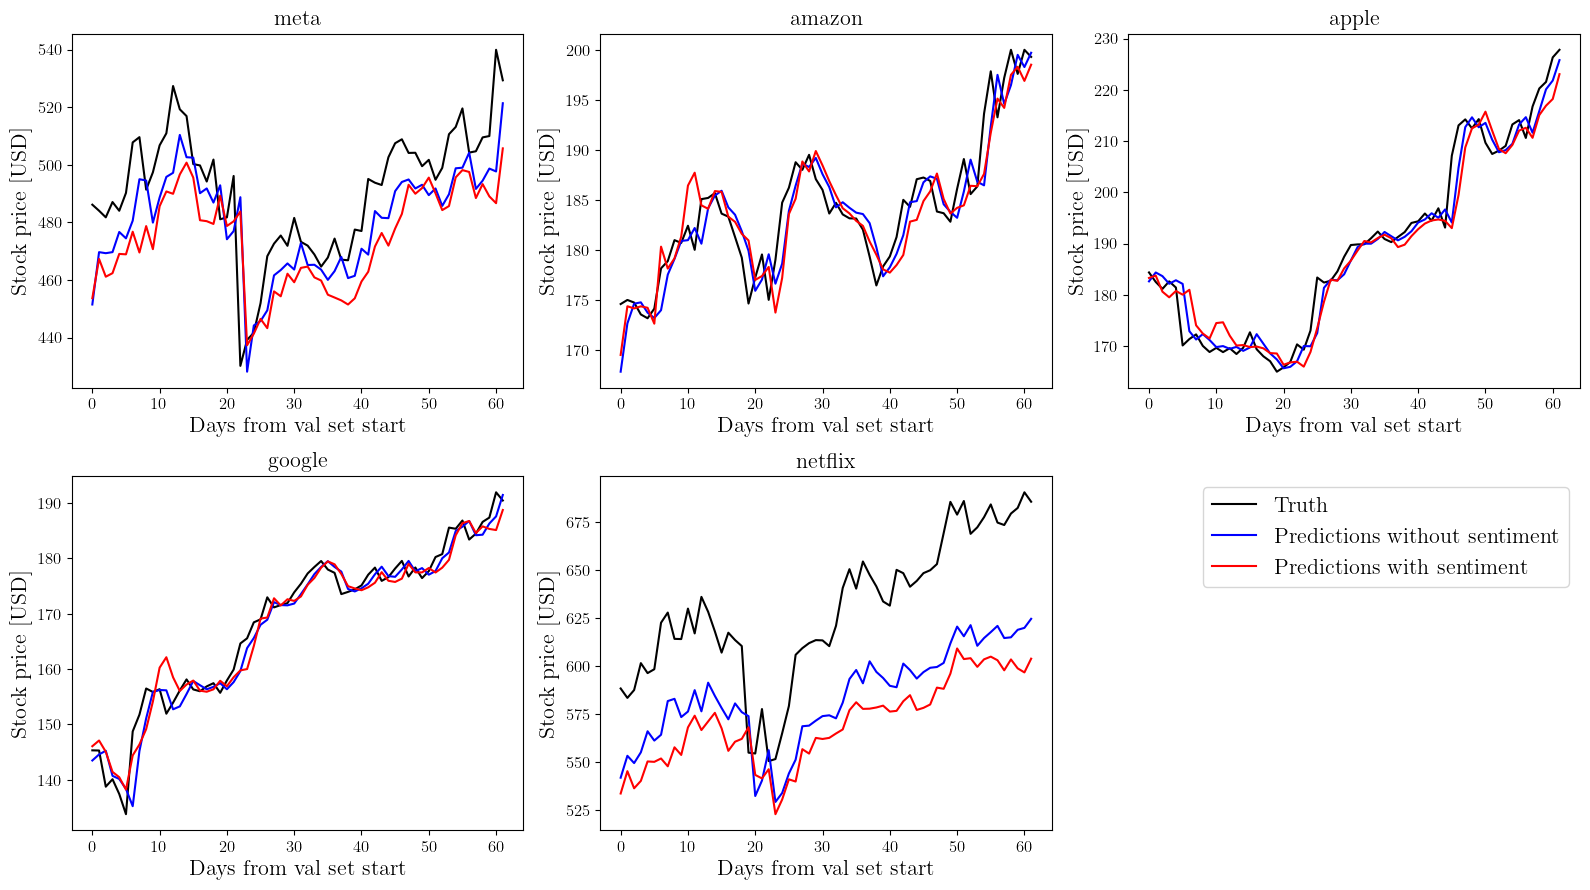

In [7]:
def unnormalize(y):
    return y * price_std + price_mean

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 9))

ax = ax.flatten()

for i in range(len(Xy_val)):
    X, y = Xy_val[i]
    stock_name = STOCK_PATHS[i].split("/")[-1].split(".csv")[0]

    with torch.no_grad():
        y_val_pred_no_sentiment = model_no_sentiment(X[:, :, 0:1])
        y_val_pred_sentiment = model_sentiment(X)

    print(f"[{stock_name}] No sentiment loss = {unnormalize(((y - y_val_pred_no_sentiment) ** 2).mean()):.5f} USD\n\tSentiment loss = {unnormalize(((y - y_val_pred_sentiment) ** 2).mean()):.5f} USD\n")

    ax[i].plot(unnormalize(y), color="black", label="Truth")
    ax[i].plot(unnormalize(y_val_pred_no_sentiment), color="blue", label="Predictions without sentiment")
    ax[i].plot(unnormalize(y_val_pred_sentiment), color="red", label="Predictions with sentiment")

    ax[i].set_xlabel("Days from val set start", fontsize=16)
    ax[i].set_ylabel("Stock price [USD]", fontsize=16)

    ax[i].tick_params(axis="both", labelsize=12)

    ax[i].set_title(stock_name, fontsize=16)

# for j in range(len(Xy_val), len(ax)):
#     fig.delaxes(ax[j]) 

ax[-1].plot([], color="black", label="Truth")
ax[-1].plot([], color="blue", label="Predictions without sentiment")
ax[-1].plot([], color="red", label="Predictions with sentiment")
ax[-1].legend(fontsize=16)
ax[-1].axis("off")

plt.tight_layout()

plt.show()

### Test set

[meta] No sentiment loss = 1512.63123 USD
	Sentiment loss = 1536.09448 USD

[amazon] No sentiment loss = 175.91341 USD
	Sentiment loss = 175.58252 USD

[apple] No sentiment loss = 206.16104 USD
	Sentiment loss = 204.58842 USD

[google] No sentiment loss = 176.52013 USD
	Sentiment loss = 177.13666 USD

[netflix] No sentiment loss = 3103.24390 USD
	Sentiment loss = 3170.42871 USD



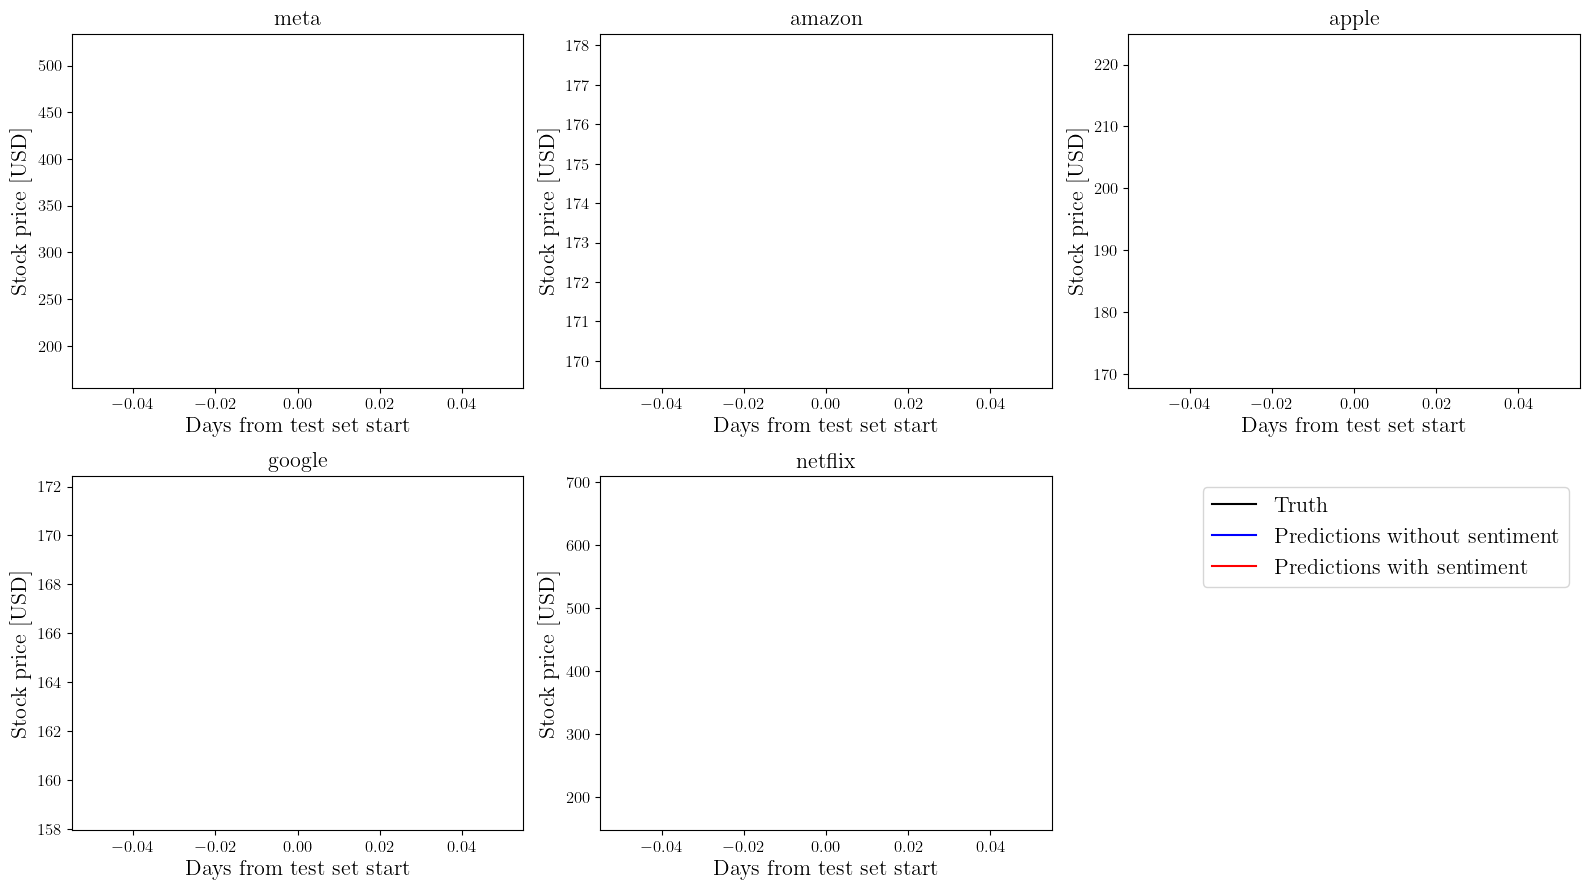

In [9]:
def unnormalize(y):
    return y * price_std + price_mean

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 9))

ax = ax.flatten()

for i in range(len(Xy_test)):
    X, y = Xy_test[i]
    stock_name = STOCK_PATHS[i].split("/")[-1].split(".csv")[0]


    with torch.no_grad():
        y_test_pred_no_sentiment = model_no_sentiment(X[:, :, 0:1])
        y_test_pred_sentiment = model_sentiment(X)

    print(f"[{stock_name}] No sentiment loss = {unnormalize(((y - y_test_pred_no_sentiment) ** 2).mean()):.5f} USD\n\tSentiment loss = {unnormalize(((y - y_test_pred_sentiment) ** 2).mean()):.5f} USD\n")

    ax[i].plot(unnormalize(y), color="black", label="Truth")
    ax[i].plot(unnormalize(y_test_pred_no_sentiment), color="blue", label="Predictions without sentiment")
    ax[i].plot(unnormalize(y_test_pred_sentiment), color="red", label="Predictions with sentiment")

    ax[i].set_xlabel("Days from test set start", fontsize=16)
    ax[i].set_ylabel("Stock price [USD]", fontsize=16)

    ax[i].tick_params(axis="both", labelsize=12)

    ax[i].set_title(stock_name, fontsize=16)

# for j in range(len(Xy_test), len(ax)):
#     fig.delaxes(ax[j]) 

ax[-1].plot([], color="black", label="Truth")
ax[-1].plot([], color="blue", label="Predictions without sentiment")
ax[-1].plot([], color="red", label="Predictions with sentiment")
ax[-1].legend(fontsize=16)
ax[-1].axis("off")

plt.tight_layout()

plt.show()